In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The following Jupyter notebook will contain analysis of data from the Bahrein GP that took pace between January 12 - January 16 on F1 Clash. However, methods developed here can be reused for subsequent GPs, or modified to answer new questions about the performance data collected.
The data comes from players belonging to the Elite F1 clan. Clans in F1 consist of a maximum of 50 players, and this particular clan is mainly based in Brazil. F1 Clash works through servers, which means that most Elite F1 players are in the South America server.

As of now, there are TWO main questions Elite F1 would like to know:  
1. What player performance associates stronly with the easiness of the Final Round groups on Sundays?
2. What player performance associates with falling with other fellow players in the same groups? Essentially, Elite F1 wants to understand how players are assigned to groups.

I have ideas about answering the first question. We can simply use linear regression (see: https://machinelearningmastery.com/linear-regression-for-machine-learning/) to see if a pattern emerges.

#### Importing libraries. Making my life easier!

In [2]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm, trange

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

#### Reading the data

In [4]:
raw_data = pd.read_csv("../data/GP_220116.csv")
# raw_data

Alright, the data isn't too bad for what I want to do. My hypothesis is that the easiness of the Final Round groups can be associated with performance on Qualifying and Opening rounds (Qualy and Saturday, respectively). This comes from reading Discord and group chats, where people talk about keeping the number of points per race low to gain access to easier groups (a strategy known in the game as sandbagging). I have personally used this strategy, and it does seem to carry weight.  
So, our dependent variable can be `Score for P1 on his group` or `# of 470 on his group`, as the measure of easiness, and our independent variables can be scores for each day that the players raced, and the number of races.  
I won't use averages, since that can introduce co-linearities: https://machinelearningmastery.com/linear-regression-for-machine-learning/ But I'm open to include them if it becomes necessary.

#### Data clean up

In [5]:
# Subsetting the data to get the columns I want for initial analysis
# I'm going to keep names so I can locate stuff when inspecting.
# Nobody is after anybody, nor pointing the finger!
# Just in case... Stuff happens when you deal with humans lol
cleaned_data = raw_data[['Player',
                         'Score for P1 on his group', '# of 470 on his group',
                         'SAT score', 'SAT races',
                         'FRI score', 'FRI races',
                         'THU score', 'THU races',
                         'WED score', 'WED races']]

# cleaned_data

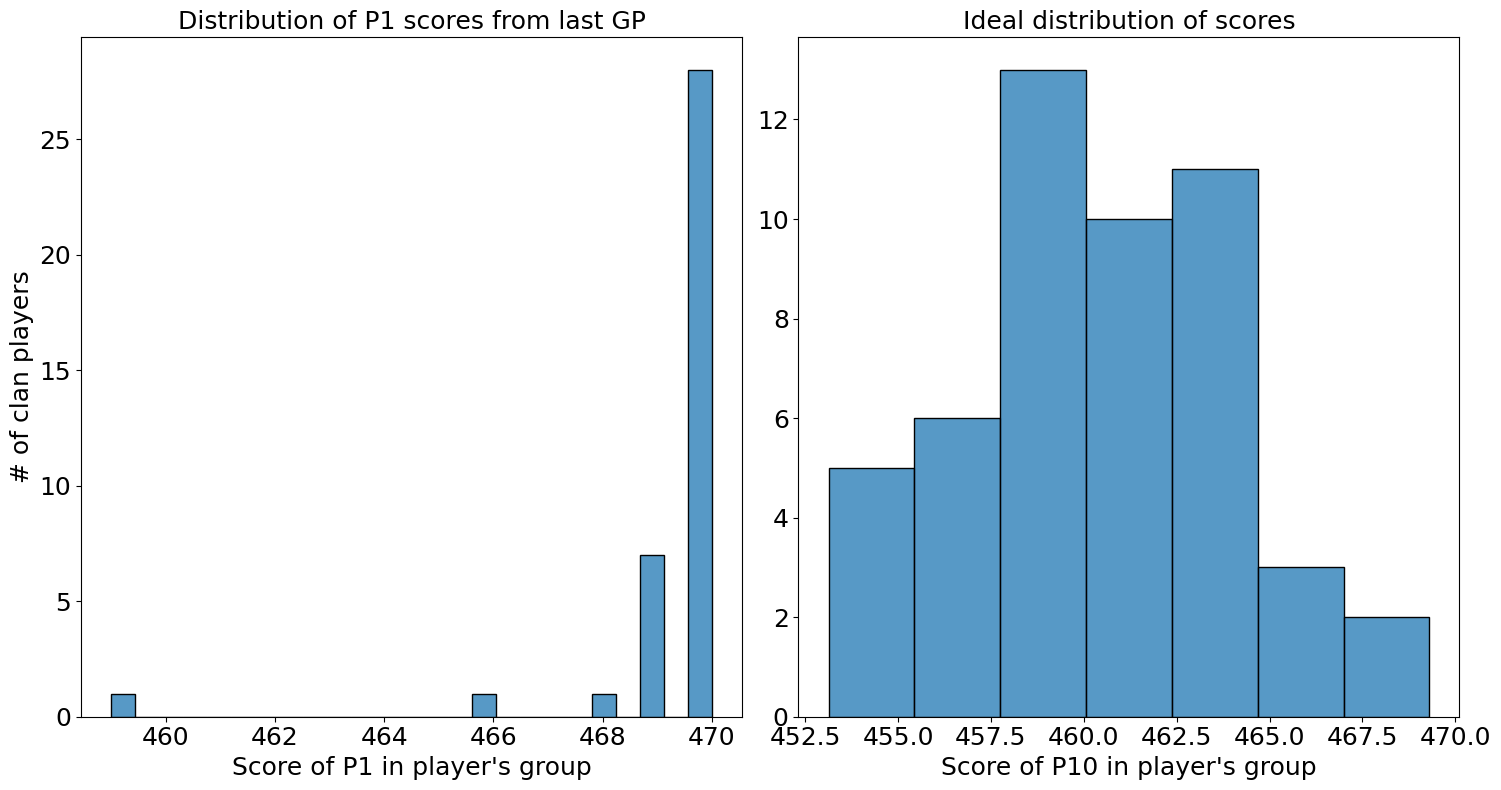

In [6]:
target_variable = cleaned_data['Score for P1 on his group'].dropna()

ideal_target_variable = np.random.normal(460,3,50)

fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.histplot(target_variable, ax=ax[0], bins='fd')
ax[0].set_ylabel('# of clan players', size=18)
ax[0].set_xlabel("Score of P1 in player's group", size=18)
ax[0].set_title("Distribution of P1 scores from last GP", size=18)
ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)

sns.histplot(ideal_target_variable, ax=ax[1], bins='fd')
ax[1].set_xlabel("Score of P10 in player's group", size=18)
ax[1].set(ylabel=None)
ax[1].set_title("Ideal distribution of scores", size=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()
# plt.savefig("figure.png")

#### No data on the easiness of the Final Round group? Can't do much with that... Deleting those rows (for all I know, that can also mean the player didn't make it to the Final Round). And again, not pointing the finger at anybody.

In [7]:
cleaned_data = cleaned_data.dropna(how='all',
                                  subset=['Score for P1 on his group',
                                          '# of 470 on his group'])
# cleaned_data

So, whenever there are missing data, one has to be really careful when dealing with that. Sometimes data is missing randomly, and when that's the case, there are well established methods to deal with them. However, the general approach will depend on the goals and having a deep understanding of how the data is generated. In my case, I want to know whether performance on Qualifying+Opening Round impacts easiness of groups. That means I need points and races for Opening Round.  
However, I know that people can qualify on Wednesday, Thursday, or Friday, so that if somebody qualifies on Wednesday, no data will be present for Thursday and Friday. That's OK, and what I can do is fill up those entries with zeroes.  
The problem would be if somebody qualified on Thursday, but no information is given for what happened on Wednesday. It's anybody's guess. Did that person just not race on Wednesday (in which case I can perfectly assign zero)? Or did that person race 3 times, but we don't have that info (in which case, assigning zero would cause serious problems).  
#### What I see above is that we are also missing scores and races for the Opening Round. I can't do much with that either.

In [8]:
cleaned_data = cleaned_data.dropna(how='all',
                                  subset=['SAT score',
                                          'SAT races'])
# cleaned_data

There are two players who have the situation I mentioned above. Looking at the other columns to see if they do have information.  
For one player, the issue was with his account, so he could not race on Thursday and Wednesday. I can safely assume I can place zeroes there.\*  
For another player, he entered the clan on Saturday, and could not remember his qualy score. This data point is unreliable, so it should be eliminated.

\*But this brings another dimension: Does it matter if you entered the event on Friday and raced only on Friday (same for Thursday), or does it matter if you enter the event on Wednesday, and simply don't race until Friday?

In [9]:
cleaned_data = cleaned_data.loc[cleaned_data['Player'] != "Jose Melos"].drop(axis='columns',
                                                                             columns='Player')
cleaned_data

,Score for P1 on his group,# of 470 on his group,SAT score,SAT races,FRI score,FRI races,THU score,THU races,WED score,WED races
0,468.0,0.0,322.0,10.0,NaN,NaN,NaN,NaN,164.0,5.0
1,470.0,6.0,310.0,10.0,146.0,5.0,132.0,5.0,130.0,5.0
2,470.0,1.0,346.0,10.0,NaN,NaN,NaN,NaN,147.0,5.0
4,470.0,2.0,436.0,10.0,NaN,NaN,145.0,5.0,0.0,0.0
5,470.0,2.0,436.0,10.0,NaN,NaN,NaN,NaN,145.0,5.0
7,470.0,1.0,468.0,10.0,235.0,5.0,99.0,5.0,100.0,5.0
8,470.0,1.0,303.0,10.0,152.0,5.0,130.0,5.0,130.0,5.0
9,470.0,1.0,303.0,10.0,153.0,5.0,131.0,5.0,128.0,5.0
10,470.0,4.0,281.0,10.0,NaN,NaN,NaN,NaN,139.0,5.0
11,470.0,4.0,268.0,10.0,NaN,NaN,NaN,NaN,127.0,5.0


Now filling up with zeroes

In [10]:
cleaned_data = cleaned_data.fillna(0)
cleaned_data

,Score for P1 on his group,# of 470 on his group,SAT score,SAT races,FRI score,FRI races,THU score,THU races,WED score,WED races
0,468.0,0.0,322.0,10.0,0.0,0.0,0.0,0.0,164.0,5.0
1,470.0,6.0,310.0,10.0,146.0,5.0,132.0,5.0,130.0,5.0
2,470.0,1.0,346.0,10.0,0.0,0.0,0.0,0.0,147.0,5.0
4,470.0,2.0,436.0,10.0,0.0,0.0,145.0,5.0,0.0,0.0
5,470.0,2.0,436.0,10.0,0.0,0.0,0.0,0.0,145.0,5.0
7,470.0,1.0,468.0,10.0,235.0,5.0,99.0,5.0,100.0,5.0
8,470.0,1.0,303.0,10.0,152.0,5.0,130.0,5.0,130.0,5.0
9,470.0,1.0,303.0,10.0,153.0,5.0,131.0,5.0,128.0,5.0
10,470.0,4.0,281.0,10.0,0.0,0.0,0.0,0.0,139.0,5.0
11,470.0,4.0,268.0,10.0,0.0,0.0,0.0,0.0,127.0,5.0


#### Nice and clean data ready for exploration!

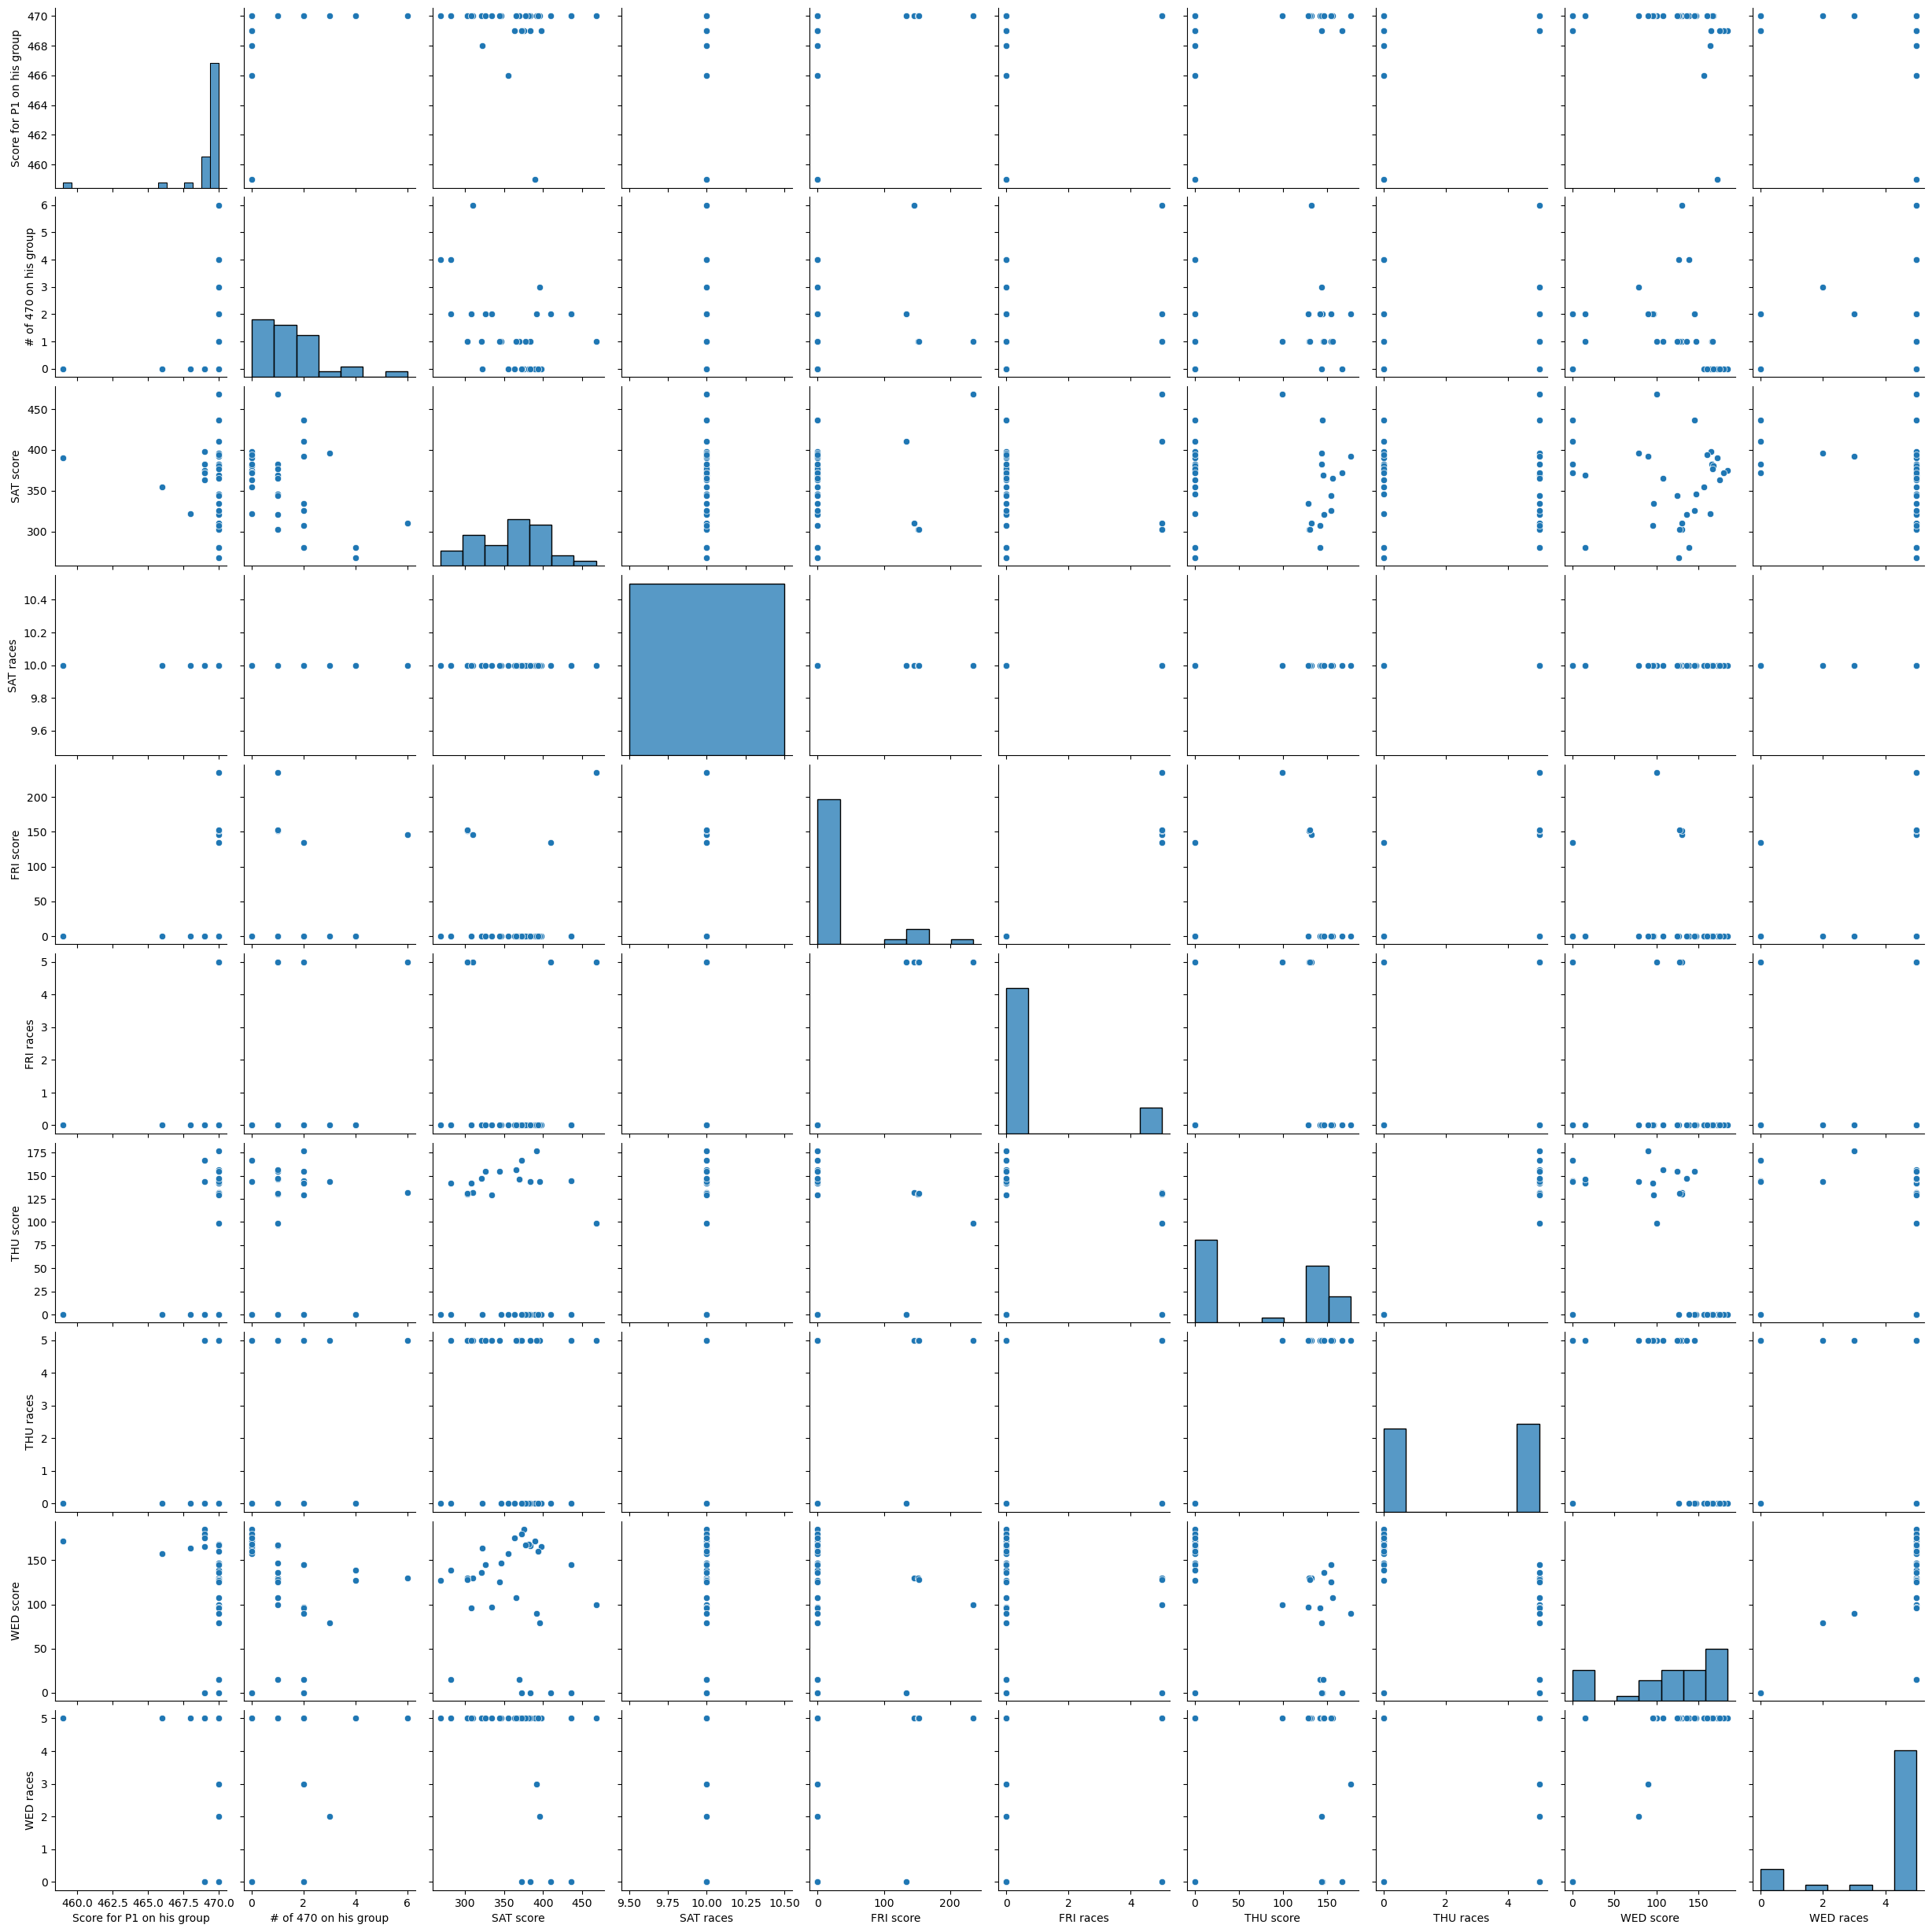

In [11]:
sns.pairplot(cleaned_data)
plt.show()

The above plot is mainly to rule out colinearities. If one exists, I would see the dot plots showing some sort of trend where as one variable goes up, the other goes up or down. But no trend is observed.  
What worries me is that linear regression usually assumes a normal distribution. But the output variables (score for P1, and # of 470) do not follow a normal distribution (bell curve). I would imagine the P10 or P5 score better following a normal distribution.  
It's just funny that the only thing that looks like a normal distribution are the Saturday scores. People were targeting a score apparently.  
Will go ahead with linear regression, but I'm already suspecting that I might need to include the averages. I also think this is difficult since I can't see a relationship between the output variables and any of the possible independent variables (no trends).

In [12]:
import statsmodels.api as sm

#### Using # of 470 on his group first

In [13]:
features = cleaned_data[['SAT score', 'SAT races',
                         'FRI score', 'FRI races',
                         'THU score', 'THU races',
                         'WED score', 'WED races']]
response = cleaned_data['# of 470 on his group']
features = sm.add_constant(features)
model = sm.OLS(response,features)
smOLS = model.fit()

C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     # of 470 on his group   R-squared:                       0.255
Model:                               OLS   Adj. R-squared:                  0.046
Method:                    Least Squares   F-statistic:                     1.220
Date:                   Sat, 22 Jan 2022   Prob (F-statistic):              0.329
Time:                           16:17:49   Log-Likelihood:                -52.638
No. Observations:                     33   AIC:                             121.3
Df Residuals:                         25   BIC:                             133.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SAT score     -0.0100      0.007     -1.383      0.179      -0.025       0.005
SAT races      0.5022      0.323      1.553      0.133      -0.164       1.168
FRI score     -0.0091      0.026     -0.349      0.730      -0.063       0.045
FRI races      0.4484      0.790      0.568      0.575      -1.179       2.075
THU score     -0.0074      0.034     -0.219      0.828      -0.077       0.062
THU races      0.2582      1.023      0.252      0.803      -1.848       2.365
WED score     -0.0041      0.008     -0.497      0.624      -0.021       0.013
WED races      0.0254      0.288      0.088      0.931      -0.568       0.619
==============================================================================
Omnibus:                        5.269   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.180
Skew:                           0.865   Prob(JB):                        0.124
Kurtosis:                       3.225   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Now using score of P1

In [15]:
features = cleaned_data[['SAT score', 'SAT races',
                         'FRI score', 'FRI races',
                         'THU score', 'THU races',
                         'WED score', 'WED races']]
response = cleaned_data['Score for P1 on his group']
features = sm.add_constant(features)
model = sm.OLS(response,features)
smOLS = model.fit()

C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Score for P1 on his group   R-squared:                       0.117
Model:                                   OLS   Adj. R-squared:                 -0.130
Method:                        Least Squares   F-statistic:                    0.4723
Date:                       Sat, 22 Jan 2022   Prob (F-statistic):              0.845
Time:                               16:17:49   Log-Likelihood:                -67.520
No. Observations:                         33   AIC:                             151.0
Df Residuals:                             25   BIC:                             163.0
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SAT score     -0.0031      0.011     -0.271      0.789      -0.026       0.020
SAT races     47.0196      0.507     92.658      0.000      45.974      48.065
FRI score      0.0033      0.041      0.082      0.936      -0.081       0.088
FRI races      0.0265      1.240      0.021      0.983      -2.528       2.581
THU score      0.0097      0.053      0.184      0.856      -0.099       0.119
THU races     -0.1567      1.606     -0.098      0.923      -3.463       3.150
WED score     -0.0082      0.013     -0.628      0.536      -0.035       0.019
WED races      0.1736      0.452      0.384      0.704      -0.758       1.105
==============================================================================
Omnibus:                       59.745   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              479.180
Skew:                          -3.913   Prob(JB):                    8.86e-105
Kurtosis:                      19.948   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Nothing to look at here  
Essentially, I wanted to see if any variable would show high coeff, and low P>t. Only SAT races does, but it does that simply because the model was so clever to realize that 47 times 10 roughly equals the score obtained by those who got P1. So smart (sarcasm)!  
Will now look at averages instead!

In [17]:
cleaned_data_2 = raw_data[['Player',
                           'Score for P1 on his group', '# of 470 on his group',
                           'Races qualy + opening',
                           'AVG qualy + opening',
                           'SAT score', 'SAT races', 'AVG 3 qualy',
                           'Actual qualy day']]

# taking away those without entries for sunday
cleaned_data_2 = cleaned_data_2.dropna(how='all',
                                       subset=['Score for P1 on his group',
                                               '# of 470 on his group'])

# taking away those without entries for saturday
cleaned_data_2 = cleaned_data_2.dropna(how='all',
                                       subset=['SAT score',
                                               'SAT races'])

# Now taking away the unreliable entry and player names
cleaned_data_2 = cleaned_data_2.loc[cleaned_data_2['Player'] != "Jose Melos"].drop(axis='columns',
                                                                                   columns='Player')

cleaned_data_2

,Score for P1 on his group,# of 470 on his group,Races qualy + opening,AVG qualy + opening,SAT score,SAT races,AVG 3 qualy,Actual qualy day
0,468.0,0.0,15,32.0,322.0,10.0,33.0,WED
1,470.0,6.0,25,29.0,310.0,10.0,27.0,FRI
2,470.0,1.0,15,33.0,346.0,10.0,29.0,WED
4,470.0,2.0,15,39.0,436.0,10.0,29.0,THU
5,470.0,2.0,15,39.0,436.0,10.0,29.0,WED
7,470.0,1.0,25,36.0,468.0,10.0,29.0,FRI
8,470.0,1.0,25,29.0,303.0,10.0,27.0,FRI
9,470.0,1.0,25,29.0,303.0,10.0,27.0,FRI
10,470.0,4.0,15,28.0,281.0,10.0,28.0,WED
11,470.0,4.0,15,26.0,268.0,10.0,25.0,WED


Getting Saturday average and keeping just the averages

In [18]:
cleaned_data_2['SAT_avg'] = cleaned_data_2['SAT score']/cleaned_data_2['SAT races']
cleaned_data_2 = cleaned_data_2[['Score for P1 on his group', '# of 470 on his group',
                                 'Races qualy + opening',
                                 'AVG qualy + opening',
                                 'AVG 3 qualy', 'SAT_avg',
                                 'Actual qualy day']]

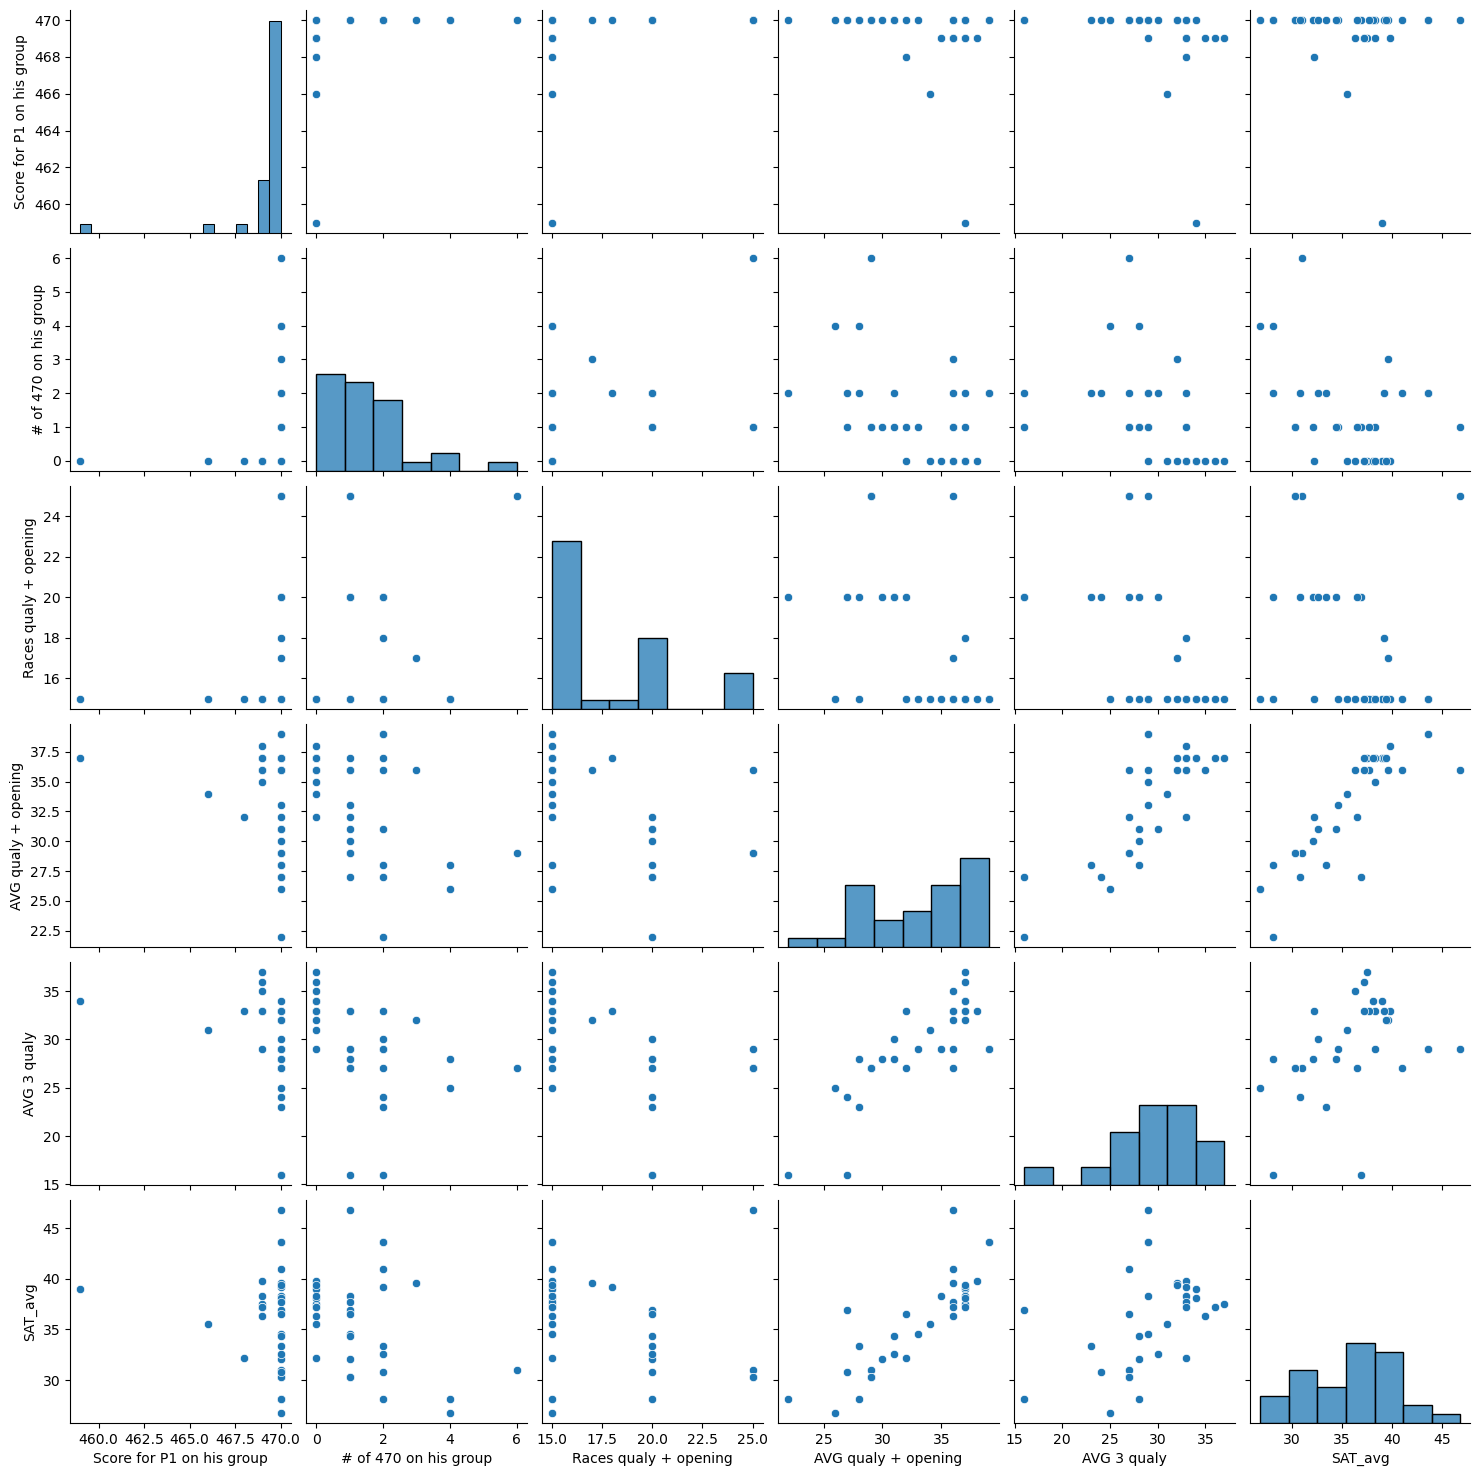

In [19]:
sns.pairplot(cleaned_data_2)
plt.show()
# plt.savefig('../visual.png')

#### This looks better! But there seems to be a strong co-linearity between average for qualy, and average for Saturday. In a way, this simply reflects strategies: Players sandbagging on both stages (to various degrees), or players going all in at every stage.

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

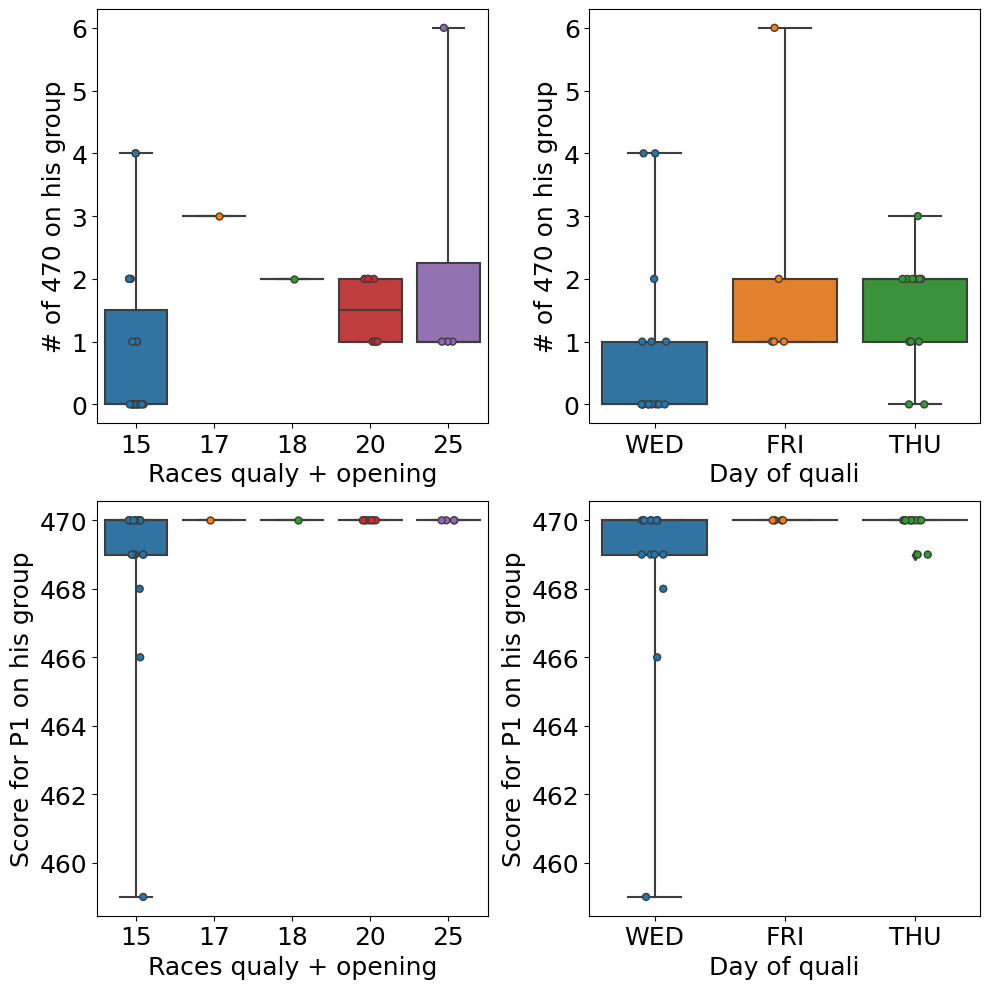

In [20]:
fig5,ax5 = plt.subplots(2,2, figsize=(10,10))
sns.stripplot(x="Races qualy + opening", y="# of 470 on his group",
              data=cleaned_data_2, ax=ax5[0,0], linewidth=1)
sns.boxplot(x="Races qualy + opening", y="# of 470 on his group",
            data=cleaned_data_2, ax=ax5[0,0], whis=np.inf)
ax5[0,0].set_ylabel('# of 470 on his group', size=18)
ax5[0,0].set_xlabel("Races qualy + opening", size=18)
ax5[0,0].tick_params(axis='x', labelsize=18)
ax5[0,0].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Actual qualy day", y="# of 470 on his group",
              data=cleaned_data_2, ax=ax5[0,1], linewidth=1)
sns.boxplot(x="Actual qualy day", y="# of 470 on his group",
            data=cleaned_data_2, ax=ax5[0,1], whis=np.inf)
ax5[0,1].set_ylabel('# of 470 on his group', size=18)
ax5[0,1].set_xlabel("Day of quali", size=18)
ax5[0,1].tick_params(axis='x', labelsize=18)
ax5[0,1].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Races qualy + opening", y="Score for P1 on his group",
              data=cleaned_data_2, ax=ax5[1,0], linewidth=1)
sns.boxplot(x="Races qualy + opening", y="Score for P1 on his group",
            data=cleaned_data_2, ax=ax5[1,0], whis=np.inf)
ax5[1,0].set_ylabel('Score for P1 on his group', size=18)
ax5[1,0].set_xlabel("Races qualy + opening", size=18)
ax5[1,0].tick_params(axis='x', labelsize=18)
ax5[1,0].tick_params(axis='y', labelsize=18)

sns.stripplot(x="Actual qualy day", y="Score for P1 on his group",
              data=cleaned_data_2, ax=ax5[1,1], linewidth=1)
sns.boxplot(x="Actual qualy day", y="Score for P1 on his group",
              data=cleaned_data_2, ax=ax5[1,1], whis=np.inf)
ax5[1,1].set_ylabel('Score for P1 on his group', size=18)
ax5[1,1].set_xlabel("Day of quali", size=18)
ax5[1,1].tick_params(axis='x', labelsize=18)
ax5[1,1].tick_params(axis='y', labelsize=18)

plt.tight_layout()
# plt.savefig("difficulty_group_races.png")
plt.show()

#### Linear regression
This is looking better, so I'll further rescale the variables so the results can be better interpreted

In [21]:
# Don't want to deal with the numpy -> pandas conversion
# AKA, no sklearn
features = cleaned_data_2[['AVG qualy + opening', 'Races qualy + opening',
                           'AVG 3 qualy','SAT_avg']]

cleaned_data_2[['AVG qualy + opening',
                'Races qualy + opening',
                'AVG 3 qualy',
                'SAT_avg']] = (features - features.min())/(features.max() -features.min())

C:\Users\USUARIO\anaconda3\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
print(f"Number of players with complete average data: {len(cleaned_data_2)}")

Number of players with complete average data: 33


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
features = cleaned_data_2[['AVG qualy + opening', 'Races qualy + opening', 'SAT_avg', 'AVG 3 qualy', 'Actual qualy day']]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [4])], remainder='passthrough')
trans_features = ct.fit_transform(features)
features_trans = pd.DataFrame(trans_features, index=features.index, columns=['FRI','THU','WED',
                                                                             'AVG qualy + opening',
                                                                             'Races qualy + opening',
                                                                             'SAT_avg','AVG 3 qualy'])

## \# of 470

In [24]:
response = cleaned_data_2['# of 470 on his group']
model = sm.OLS(response, features_trans)
smOLS = model.fit()
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     # of 470 on his group   R-squared:                       0.285
Model:                               OLS   Adj. R-squared:                  0.120
Method:                    Least Squares   F-statistic:                     1.724
Date:                   Sat, 22 Jan 2022   Prob (F-statistic):              0.155
Time:                           16:17:57   Log-Likelihood:                -51.960
No. Observations:                     33   AIC:                             117.9
Df Residuals:                         26   BIC:                             128.4
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
FRI                       4.2242      1.655      2.553      0.017       0.823       7.626
THU                       3.1961      1.047      3.053      0.005       1.044       5.348
WED                       2.8546      1.047      2.727      0.011       0.703       5.007
AVG qualy + opening       1.8060      5.884      0.307      0.761     -10.288      13.900
Races qualy + opening    -0.4187      1.511     -0.277      0.784      -3.526       2.688
SAT_avg                  -2.9732      4.019     -0.740      0.466     -11.235       5.289
AVG 3 qualy              -2.5430      3.507     -0.725      0.475      -9.751       4.665
==============================================================================
Omnibus:                        7.900   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.521
Skew:                           1.037   Prob(JB):                       0.0384
Kurtosis:                       3.665   Cond. No.                         43.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening']))
smOLS = model.fit()
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     # of 470 on his group   R-squared:                       0.282
Model:                               OLS   Adj. R-squared:                  0.150
Method:                    Least Squares   F-statistic:                     2.126
Date:                   Sat, 22 Jan 2022   Prob (F-statistic):             0.0928
Time:                           16:17:57   Log-Likelihood:                -52.009
No. Observations:                     33   AIC:                             116.0
Df Residuals:                         27   BIC:                             125.0
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
FRI                     3.8444      0.911      4.219      0.000       1.975       5.714
THU                     2.9951      0.741      4.039      0.000       1.474       4.516
WED                     2.7560      0.968      2.848      0.008       0.771       4.741
AVG qualy + opening     2.7252      4.775      0.571      0.573      -7.073      12.523
SAT_avg                -3.4822      3.513     -0.991      0.330     -10.691       3.726
AVG 3 qualy            -3.0109      3.020     -0.997      0.328      -9.207       3.186
==============================================================================
Omnibus:                        7.496   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                6.111
Skew:                           1.009   Prob(JB):                       0.0471
Kurtosis:                       3.613   Cond. No.                         35.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening','AVG qualy + opening']))
smOLS = model.fit()
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     # of 470 on his group   R-squared:                       0.274
Model:                               OLS   Adj. R-squared:                  0.170
Method:                    Least Squares   F-statistic:                     2.640
Date:                   Sat, 22 Jan 2022   Prob (F-statistic):             0.0548
Time:                           16:17:57   Log-Likelihood:                -52.207
No. Observations:                     33   AIC:                             114.4
Df Residuals:                         28   BIC:                             121.9
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
FRI             3.7078      0.869      4.269      0.000       1.929       5.487
THU             2.9029      0.715      4.061      0.000       1.438       4.367
WED             2.7347      0.955      2.863      0.008       0.778       4.691
SAT_avg        -1.5748      1.070     -1.472      0.152      -3.766       0.616
AVG 3 qualy    -1.4605      1.303     -1.121      0.272      -4.130       1.209
==============================================================================
Omnibus:                        8.019   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.770
Skew:                           1.073   Prob(JB):                       0.0339
Kurtosis:                       3.566   Cond. No.                         8.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model = sm.OLS(response, features_trans.drop(columns=['Races qualy + opening','AVG qualy + opening', 'AVG 3 qualy']))
smOLS = model.fit()
smOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     # of 470 on his group   R-squared:                       0.241
Model:                               OLS   Adj. R-squared:                  0.163
Method:                    Least Squares   F-statistic:                     3.074
Date:                   Sat, 22 Jan 2022   Prob (F-statistic):             0.0432
Time:                           16:17:57   Log-Likelihood:                -52.931
No. Observations:                     33   AIC:                             113.9
Df Residuals:                         29   BIC:                             119.8
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FRI            3.1594      0.721      4.384      0.000       1.685       4.633
THU            2.3905      0.552      4.330      0.000       1.261       3.520
WED            1.8676      0.563      3.320      0.002       0.717       3.018
SAT_avg       -2.1132      0.960     -2.202      0.036      -4.076      -0.150
==============================================================================
Omnibus:                        5.999   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                4.868
Skew:                           0.930   Prob(JB):                       0.0877
Kurtosis:                       3.285   Cond. No.                         4.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Yeap, cannot conclude much from Linear Regression. When evaluating each average individually (not shown), I couldn't also see statistically significant coefficients.  
  
  ### Idea: Let's use score of whoever ends on P10 as the measure of easiness of the Sunday group. I expect this score to follow a bell curve better than the score of P1 (which is very skewed towards 470). Essentially, that will be the score above which players could get good medals in the event, and not just the generic finalist medal. It will also be on the same terms as the other variables, since they are also scores. I could simply divide those scores by 10, and then normalize, to have very pretty dataset for linear regression.

However, there are other ideas floating around. It turns out that players ending up together on Saturday's Opening round tend to also end up together in the Final round. It would be difficult to assess that with this data, since players may sandbag or go all-in on Saturday, so their scores aren't a reflection of their true skill level.  
But I could test, later on, if this notion is true, if I quantify clustering on saturday, and see if it is any different on sunday. The problem there is that I would need data on all players, not just Elite F1.

#### Let's simply look at groups, whether they share general traits

In [28]:
groupings_data = raw_data[['Player', 'SUN DAY group', 'SAT group', 'AVG qualy + opening',
                           'SAT score', 'SAT races', 'AVG 3 qualy', 'Races qualy + opening', 'Actual qualy day']]

groupings_data['SAT_avg'] = groupings_data['SAT score']/groupings_data['SAT races']
groupings_data = groupings_data[['SUN DAY group','SAT group',
                                 'AVG qualy + opening', 'SAT_avg',
                                 'AVG 3 qualy', 'Races qualy + opening', 'Actual qualy day']]

# taking away those without entries for Sunday groups
groupings_data = groupings_data.dropna(how='all',
                                       subset=['SUN DAY group'])

# taking away those without entries for averages
groupings_data = groupings_data.dropna(how='any',
                                       subset=['AVG qualy + opening',
                                               'SAT_avg',
                                               'AVG 3 qualy'])

groupings_data.sort_values(by='SUN DAY group')

<ipython-input-28-7e0f01f5abec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupings_data['SAT_avg'] = groupings_data['SAT score']/groupings_data['SAT races']


,SUN DAY group,SAT group,AVG qualy + opening,SAT_avg,AVG 3 qualy,Races qualy + opening,Actual qualy day
0,NA1,NaN,32.0,32.2,33.0,15,WED
1,NA2,NaN,29.0,31.0,27.0,25,FRI
2,SA1,D,33.0,34.6,29.0,15,WED
4,SA10,D,39.0,43.6,29.0,15,THU
5,SA10,D,39.0,43.6,29.0,15,WED
7,SA11,-,36.0,46.8,29.0,25,FRI
8,SA11,NaN,29.0,30.3,27.0,25,FRI
9,SA11,-,29.0,30.3,27.0,25,FRI
13,SA12,NaN,36.0,41.0,27.0,15,FRI
10,SA12,W,28.0,28.1,28.0,15,WED


#### Sunday grouping logic

In [29]:
# Taking away groups where only one person was present
# f = groupings_data['SUN DAY group'].value_counts()
# groupings_data = groupings_data[groupings_data['SUN DAY group'].isin(f[f>1].index)]

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

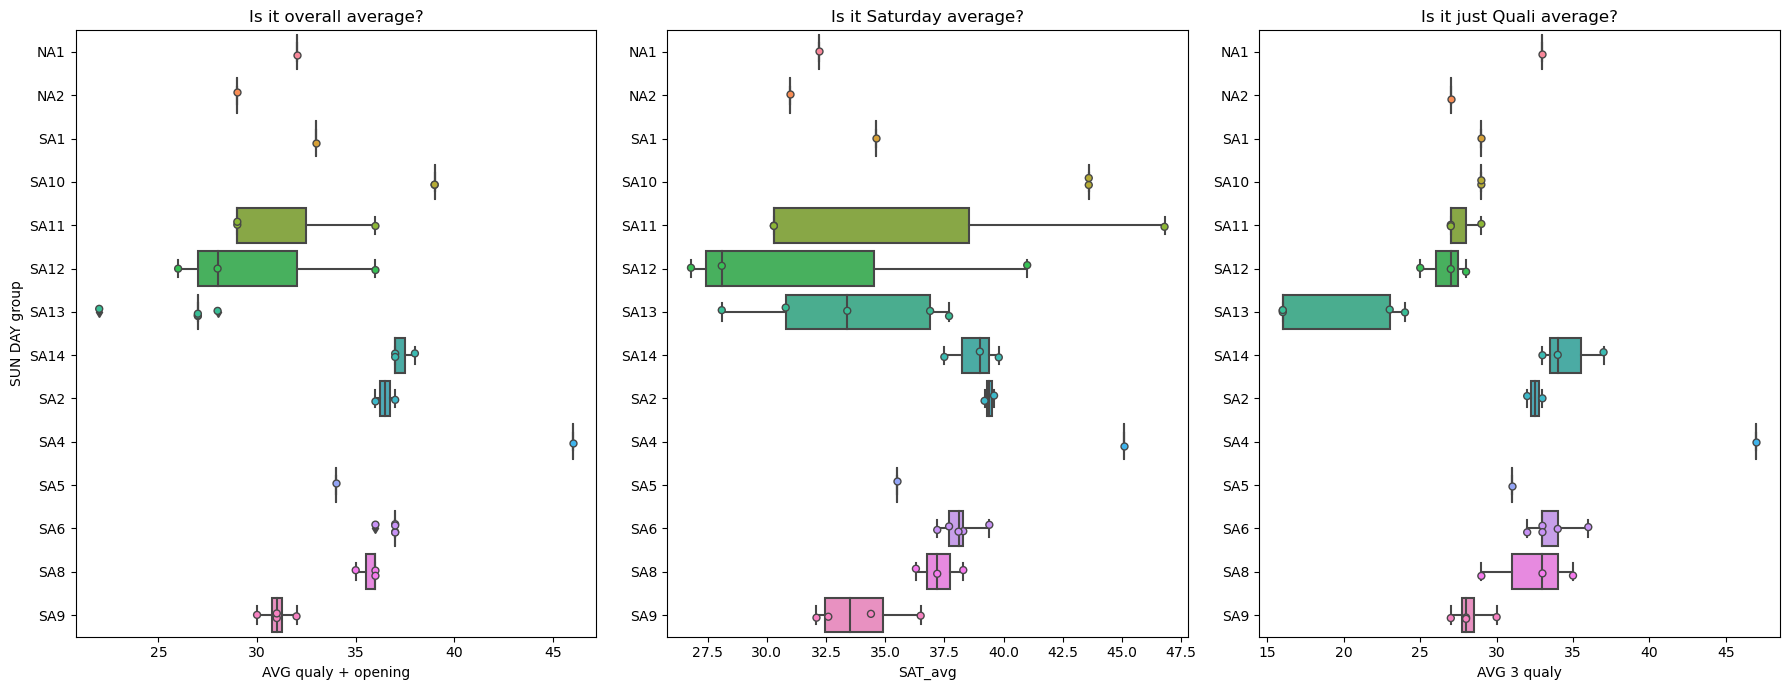

In [30]:
fig1, ax1 = plt.subplots(1,3, figsize=(18,7))
sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax1[0], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax1[0], linewidth=1)
ax1[0].set_title("Is it overall average?")

sns.boxplot(x="SAT_avg", y="SUN DAY group",
              data=groupings_data, ax=ax1[1], whis=np.inf)
sns.stripplot(x="SAT_avg", y="SUN DAY group",
              data=groupings_data, ax=ax1[1], linewidth=1)
ax1[1].set(ylabel=None)
ax1[1].set_title("Is it Saturday average?")

sns.boxplot(x="AVG 3 qualy", y="SUN DAY group",
              data=groupings_data, ax=ax1[2], whis=np.inf)
sns.stripplot(x="AVG 3 qualy", y="SUN DAY group",
              data=groupings_data, ax=ax1[2], linewidth=1)
ax1[2].set(ylabel=None)
ax1[2].set_title("Is it just Quali average?")

plt.tight_layout()
plt.show()
# plt.savefig("grouping_by_average.png")

#### Saturday logic

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

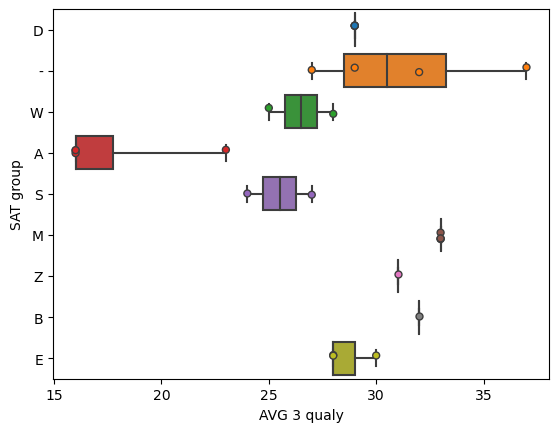

In [31]:
fig2, ax2 = plt.subplots(1,1)
sns.boxplot(x="AVG 3 qualy", y="SAT group",
              data=groupings_data.dropna(), ax=ax2, whis=np.inf)
sns.stripplot(x="AVG 3 qualy", y="SAT group",
              data=groupings_data.dropna(), ax=ax2, linewidth=1)

plt.show()

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

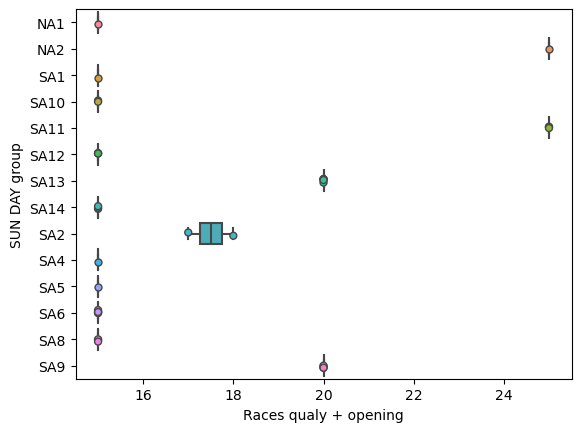

In [32]:
fig3, ax3 = plt.subplots(1,1)
sns.boxplot(x="Races qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax3, whis=np.inf)
sns.stripplot(x="Races qualy + opening", y="SUN DAY group",
              data=groupings_data, ax=ax3, linewidth=1)

# plt.savefig("number_of_races.png")
plt.show()

### Co-occurrence of Saturday group vs. Sunday group

In [33]:
groupings = groupings_data[['SUN DAY group','SAT group', 'Races qualy + opening',
                            'Actual qualy day']].dropna()
f = groupings['SAT group'] != '-'
groupings.loc[f].sort_values(by='SAT group')

,SUN DAY group,SAT group,Races qualy + opening,Actual qualy day
15,SA13,A,20,THU
16,SA13,A,20,THU
18,SA13,A,20,THU
19,SA13,A,20,THU
32,SA6,B,15,WED
2,SA1,D,15,WED
4,SA10,D,15,THU
5,SA10,D,15,WED
36,SA8,D,15,THU
42,SA9,E,20,THU


## there seems to be a hierarchy or a sequential criteria applied to determine groups. Among those with 15 races, what was their average?

C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
C:\Users\USUARIO\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1250: RuntimeWarning: invalid value encountered in 

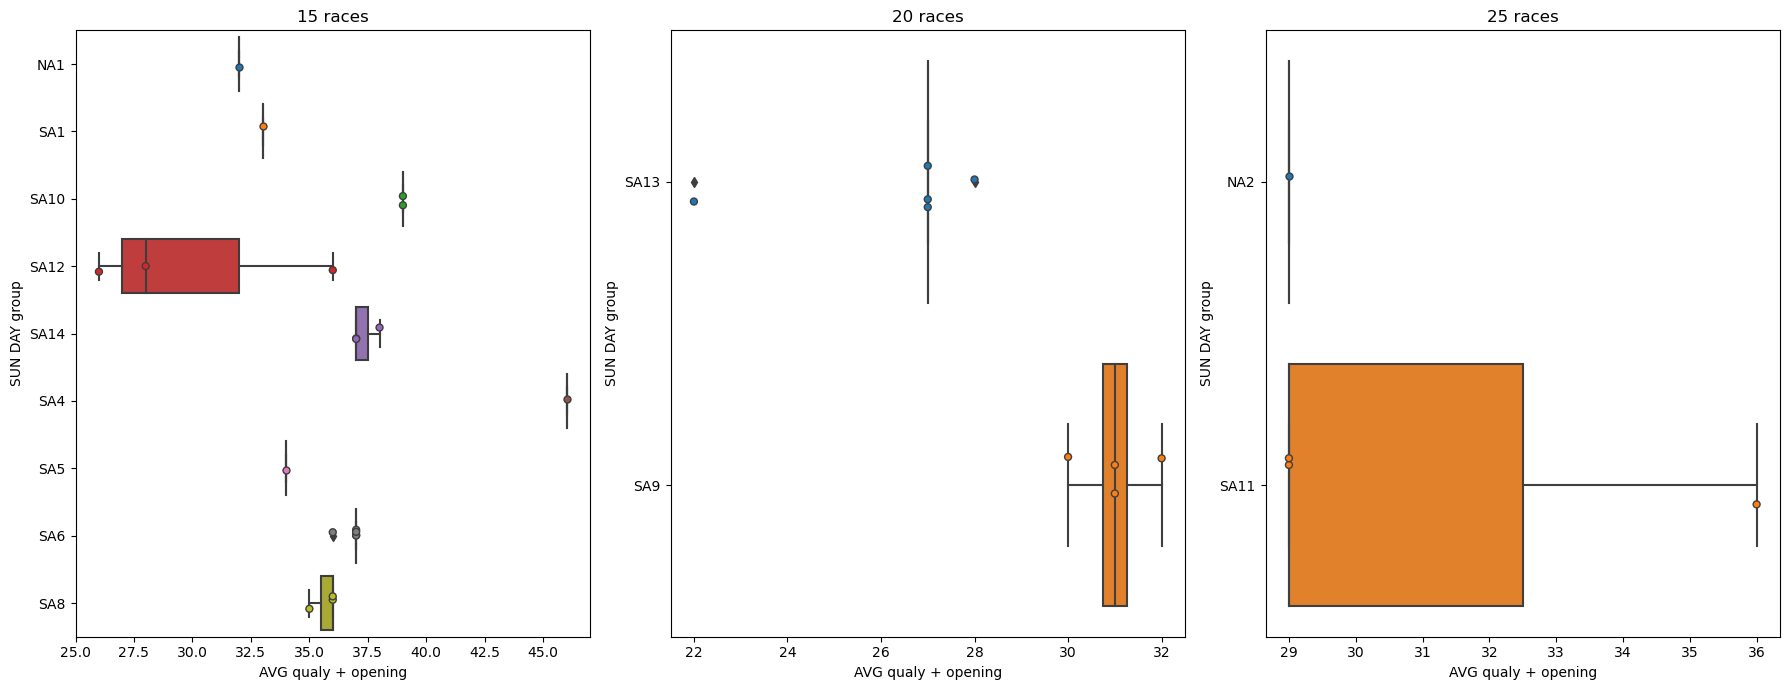

In [34]:
g = groupings_data['Races qualy + opening'] == 15
h = groupings_data['Races qualy + opening'] == 20
k = groupings_data['Races qualy + opening'] == 25

fig4, ax4 = plt.subplots(1,3,figsize=(18,7))
sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[g], ax=ax4[0], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[g], ax=ax4[0], linewidth=1)
ax4[0].set_title("15 races")

sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[h], ax=ax4[1], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[h], ax=ax4[1], linewidth=1)
ax4[1].set_title("20 races")

sns.boxplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[k], ax=ax4[2], whis=np.inf)
sns.stripplot(x="AVG qualy + opening", y="SUN DAY group",
              data=groupings_data.loc[k], ax=ax4[2], linewidth=1)
ax4[2].set_title("25 races")

plt.tight_layout()
# plt.savefig("average_spread_per_races.png")
plt.show()

hum, does it happens because we have more groups in one they them the other?
We had 10 groups for weds, 2 groups for thurs and 1 for friday  
10 groups for people who qualified with 5 races;
2 groups for people who qualified with 10 races;
1 groups for people whi qualified with 15

In [35]:
sun_friday = raw_data[['SUN DAY group', 'SAT group',
                       'Races 3 qualy',
                       'Actual qualy day']].dropna(subset=['SUN DAY group', 'Actual qualy day', 'Races 3 qualy'])
sun_friday.groupby('Races 3 qualy')['SUN DAY group'].unique()

Races 3 qualy
5     [NA1, SA1, SA10, SA12, SA14, SA4, SA5, SA6, SA7, SA8]
7                                                     [SA2]
8                                                     [SA2]
10                                              [SA13, SA9]
15                                              [NA2, SA11]
Name: SUN DAY group, dtype: object

In [36]:
sun_friday.groupby('Races 3 qualy')['SUN DAY group'].nunique()

Races 3 qualy
5     10
7      1
8      1
10     2
15     2
Name: SUN DAY group, dtype: int64